In [1]:
#IMPORTS 
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\DGaard\Desktop\Gits\MoleculeSim\ownSim")
#sys.path.append(r"C:\Users\EmilR\Documents\GitHub\MoleculeSim\ownSim")

import molecules as mc
import forces as fc
import random
import copy
from tqdm import tqdm


In [2]:
#force
threshold = 1
def custom_force1(m1,m2):
  f = fc.total_force_molecule(m1,m2,threshold=threshold)
  return f



def lin_attraction(x, b =-20):
  if x >= threshold:
    return min((1/10)*x + b,0)
  else:
    return fc.MAX_FORCE_VAL


def custom_force2(m1,m2):
  h = mc.inter_dist(m1,m2)
  return lin_attraction(h) 



In [3]:
#setup universe

# Parameters for universe initialization
box_const_size = 1000
box_size = np.array([box_const_size,box_const_size,box_const_size]) #max coordinate values for universe
#num_molecules = 5
num_steps = 1000000
radius  = 100
num_molecules = 30
#other setup
seed = 1414 #1313

#combs = grid_points(box_size, radius, spacing)
#molecules = [mc.Molecule(pos, radius) for pos in combs]

force_func = custom_force2
#uni = mc.SimpleUniverse(box_size, len(molecules),np.repeat(radius,len(molecules)),seed, own_molecules = molecules, force_fun = cust_force)
uni = mc.SimpleUniverse(box_size, num_molecules,np.repeat(radius,num_molecules),seed, force_fun = force_func)
print(type(uni.molecules[0].pos[0]))

<class 'numpy.float64'>


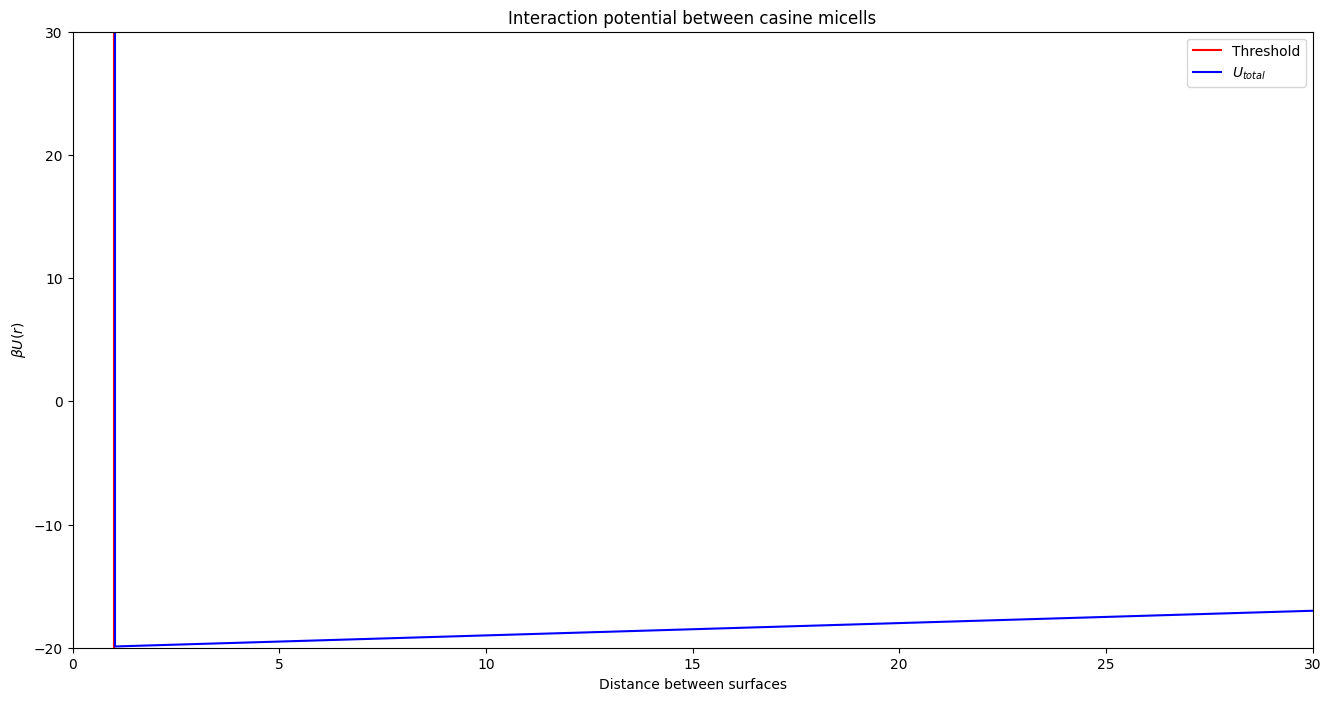

In [4]:
#plot force between two molecules:

#spawn two molecules at different distances
interdists = np.linspace(0.1,30,1000)
forces = []
for i in interdists:
  dist_between = 2*radius + i
  m1 = mc.Molecule(np.array([0.0,0.0,0.0]),radius)
  m2 = mc.Molecule(np.array([dist_between,0.0,0.0]),radius)
  f = force_func(m1,m2)
  forces.append(f)

plt.figure(figsize=(16,8))

plt.axvline(x=threshold,label = "Threshold",c="red")
plt.plot(interdists, forces, c="blue", label = "$U_{total}$")

plt.ylim((-20,30))
plt.xlim((0,30))
plt.title("Interaction potential between casine micells")
plt.xlabel("Distance between surfaces")
plt.ylabel(r"$\beta U(r)$")
plt.legend()
plt.show()



In [5]:
#see density
box_vol = box_const_size**3
print("Upper bound amount of spheres: ", box_vol/((4/3)*radius**3 * np.pi))
print("Density: ", (((4/3)*radius**3*np.pi)*num_molecules)/box_vol)

Upper bound amount of spheres:  238.73241463784302
Density:  0.1256637061435917


In [6]:
#run univers # steps
points = []

# Perform Simulation
for i in tqdm(range(num_steps)):
  #randomly select a molecule
  uni.make_step()
  #store intermediate results?
  points.append(uni.get_state())

acc, rej, accs, num = uni.get_stats()
print(f"Accepted: {acc}, Rejected: {rej}, Rate: {acc/num}")

100%|██████████| 1000000/1000000 [02:37<00:00, 6343.86it/s]

Accepted: 529289, Rejected: 470711, Rate: 0.529289


In [7]:
#extract points

#show every 100 points
frame_step_size = 100

xs = np.array([inner_list[0] for sublist in points for inner_list in sublist]).reshape((num_steps,num_molecules))
ys = np.array([inner_list[1] for sublist in points for inner_list in sublist]).reshape((num_steps,num_molecules))
zs = np.array([inner_list[2] for sublist in points for inner_list in sublist]).reshape((num_steps,num_molecules))

xs = [xs[i] for i in range(len(xs)) if i % frame_step_size == 0]
ys = [ys[i] for i in range(len(ys)) if i % frame_step_size == 0]
zs = [zs[i] for i in range(len(zs)) if i % frame_step_size == 0]

100%|██████████| 10000/10000 [00:07<00:00, 1308.61it/s]


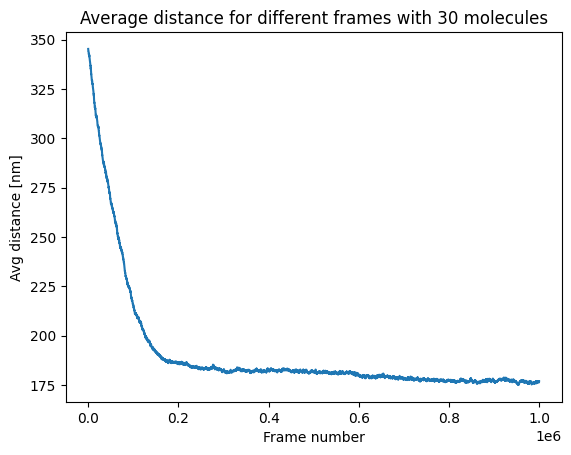

100%|██████████| 10000/10000 [00:07<00:00, 1319.22it/s]


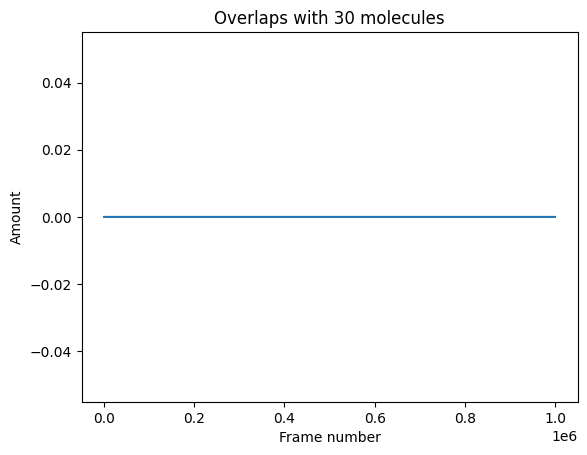

100%|██████████| 10000/10000 [00:15<00:00, 625.62it/s]


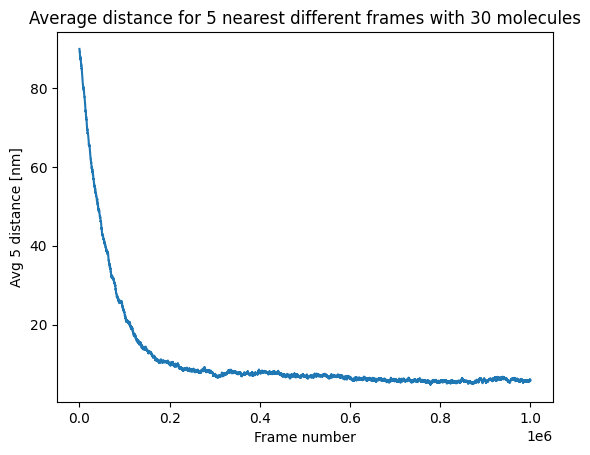

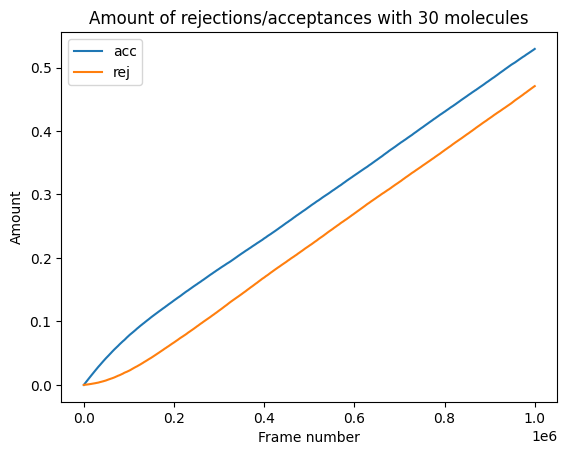

In [8]:
#calculate statistics
frame_nums = [i for i in range(0,num_steps,frame_step_size)]
point_frames = [points[frame] for frame in frame_nums]

#assumes constant radius
def check_for_overlap(frames):
    overlaps = []
    for frame in tqdm(frames):
        cum = 0
        for i in range(len(frame)):
            mol1 = frame[i]
            for j in range(i+1,len(frame)):
                mol2 = frame[j]
                current_dist = np.linalg.norm(mol2-mol1) - 2*radius
                if current_dist < 0:
                    cum += 1
        avg = cum
        overlaps.append(avg)

    return overlaps

#assumens constant radius
def avg_dist(frames,radius):
    dist = []
    for frame in tqdm(frames):
        cum = 0
        #ctr = 0
        for i in range(len(frame)):
            mol1 = frame[i]
            for j in range(i+1,len(frame)):
                mol2 = frame[j]
                current_dist = np.linalg.norm(mol2-mol1) - 2*radius
                cum += current_dist
                #ctr += 1
        #print(ctr,((len(frame)) * (len(frame)-1))/2)
        avg = cum / (((len(frame)) * (len(frame)-1))/2) #(N*(N-1)/2)
        dist.append(avg)
    return dist

#assumens constant radius
def avg_k_dist(frames,radius,k):
    dist = []
    for frame in tqdm(frames):
        cum = 0
        for i in range(len(frame)):
            mol1 = frame[i]
            cum_list = []
            for j in range(len(frame)):
                if (j != i):
                    mol2 = frame[j]
                    current_dist = np.linalg.norm(mol2-mol1) - 2*radius
                    cum_list.append(current_dist)
            cum_list = sorted(cum_list)
            cum += sum(cum_list[:k])
        avg = cum / (k*len(frame))
        dist.append(avg)
    return dist

#acceptence/rejectance rate
def mc_rate(acc_list):
    res_accs = []
    res_rejs = []

    acc_cum = 0
    rej_cum = 0
    lenght = len(acc_list)

    for i in acc_list:
        if i:
            acc_cum += 1
        else:
            rej_cum += 1


        res_accs.append(acc_cum / lenght)
        res_rejs.append(rej_cum / lenght)

    return res_accs, res_rejs

avg_dists = avg_dist(point_frames,radius)

#plot avg distance
plt.plot(frame_nums,avg_dists)
plt.title(f"Average distance for different frames with {num_molecules} molecules")
plt.xlabel("Frame number")
plt.ylabel("Avg distance [nm]")
plt.show()


overlaps = check_for_overlap(point_frames)

#plot avg distance
plt.plot(frame_nums,overlaps)
plt.title(f"Overlaps with {num_molecules} molecules")
plt.xlabel("Frame number")
plt.ylabel("Amount")
plt.show()

k = 5
k_dists = avg_k_dist(point_frames,radius,k)

#plot avg distance
plt.plot(frame_nums,k_dists)
plt.title(f"Average distance for {k} nearest different frames with {num_molecules} molecules")
plt.xlabel("Frame number")
plt.ylabel(f"Avg {k} distance [nm]")
plt.show()


acceptances, rejections = mc_rate(accs)

#plot acceptance and rejectance 
plt.plot(acceptances,label="acc")
plt.plot(rejections,label="rej")
plt.title(f"Amount of rejections/acceptances with {num_molecules} molecules")
plt.xlabel("Frame number")
plt.ylabel("Amount")
plt.legend()
plt.show()

In [9]:
#mayavi visualize
from __future__ import absolute_import, division, print_function
from mayavi import mlab
import numpy as np
import math
num_molecules = len(uni.molecules)


mlab.clf()
#mlab.points3d(0,0,0)
plt = mlab.points3d(points[0][:, 0], points[0][:, 1], points[0][:, 2], resolution = 10, scale_factor = radius*2)
mlab.axes()
text_position = (0,0,0)
text_actor = mlab.text3d(500,150, 510, "TESTING", scale = 40, color = (0,0,0))
@mlab.animate(delay = 100, ui = True, support_movie = True) #delay = 100
def anim():
    f = mlab.gcf()
    while True:
        #temp = "step: "
        for step in range(len(xs)):#num_steps
            x = xs[step]#points[step][:, 0]
            y = ys[step]#points[step][:, 1]
            z = zs[step]#points[step][:, 2]
            plt.mlab_source.set(x=x, y=y, z=z)
            text_actor.text = f"Frame: {step}"
            
            yield


anim()
mlab.show()

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [10]:
#advance interupt
0/0

ZeroDivisionError: division by zero

In [ ]:
#save points array
np.save("point_example2.npy",np.array(points))
#np.load("point_example.npy").shape